[http] https://www.kaggle.com/code/toygarr/baseline-for-almost-any-img-classification-task

In [8]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# System libraries
from pathlib import Path
import os.path
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import time

from PIL import Image
from random import randint

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools



from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow

from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101 # ResNet 101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3


import scipy


In [ ]:
#AUGMENTED DATA
aug_data = "../input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"
org_data = "../input/augmented-alzheimer-mri-dataset/OriginalDataset"

In [ ]:
image_dir = Path(aug_data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
def get_dataset(augmented = 0):
    if(augmented == 0):
        image_dir = Path(org_data)
    else:
        image_dir = Path(aug_data)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

In [ ]:
train_df = get_dataset(1)
test_df = get_dataset(0)

In [ ]:
pd.set_option('display.max_colwidth', None)
train_df.head()

In [ ]:
test_df.tail()

In [ ]:
# Display 25 picture of the augmented dataset with their labels
random_index = np.random.randint(0, len(train_df), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(plt.imread(train_df.Filepath[random_index[i]]), cv2.COLOR_BGR2RGB))
    ax.set_title(train_df.Label[random_index[i]])
plt.tight_layout()
plt.savefig("Augmented.pdf")

plt.show()

In [ ]:
# Display 25 picture of the original dataset with their labels
random_index = np.random.randint(0, len(test_df), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(plt.imread(test_df.Filepath[random_index[i]]), cv2.COLOR_BGR2RGB))
    ax.set_title(test_df.Label[random_index[i]])
plt.tight_layout()
plt.savefig("Original.pdf")
plt.show()

In [ ]:
print("Train data set label distribution:\n",train_df.Label.value_counts())

print("\nTest data set label distribution:\n", test_df.Label.value_counts())

In [6]:
base_dir = "/Users/yillysaurus/PycharmProjects/class_project/Alzheimer_s Dataset/"
root_dir = "./"
train_dir = base_dir + "train"
test_dir = base_dir + "test"
#work_dir = root_dir + "dataset/"

#if os.path.exists(work_dir):
#    remove_tree(work_dir)


#os.mkdir(work_dir)
#copy_tree(train_dir, work_dir)
#copy_tree(test_dir, work_dir)
#print("Working Directory Contents:", os.listdir(work_dir))

In [7]:
#WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [9]:
datagen = IDG(rescale = 1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True)

validation_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=True)

test_gen = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=6400,
                                             class_mode='categorical')

Found 4610 images belonging to 4 classes.
Found 511 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [10]:
test_gen_plot = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical')

Found 1279 images belonging to 4 classes.


In [11]:
def plot_training_metrics(train_hist, model, test_gen_plot, y_actual, y_pred, classes, model_name):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """

    # Evaluate the results:
    #. test_metrics[0] = loss,
    #  test_metrics[1] = auc,
    #  test_metrics[2] = acc
    # Evaluate the results:
    test_metrics = model.evaluate(test_gen_plot, verbose = False)
    AUC       = test_metrics[1]*100
    Acc       = test_metrics[2]*100
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))


    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)

    # create plots
    plt.subplots(figsize=(12,4))

    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[AUC/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()


     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

In [12]:
def prepare_for_test(model, test_gen):
    data, y_true = test_gen.next()
    y_pred_ = model.predict(data, batch_size = 64)
    y_pred = []
    for i in range(y_pred_.shape[0]):
        y_pred.append(np.argmax(y_pred_[i]))

    y_true = np.argmax(y_true, axis=1)

    return y_true, y_pred

## MODELS
###VGG 19

In [13]:
vgg = VGG19(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 88, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 88, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 88, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 44, 128)       0     

Epoch 1/10
3/3 [==============================] - 276s 96s/step - loss: 1.5550 - auc: 0.6531 - acc: 0.3020 - val_loss: 1.2243 - val_auc: 0.8093 - val_acc: 0.5538
Epoch 2/10
3/3 [==============================] - 231s 81s/step - loss: 1.2260 - auc: 0.7329 - acc: 0.3673 - val_loss: 1.3237 - val_auc: 0.6288 - val_acc: 0.2720
Epoch 3/10
3/3 [==============================] - 301s 117s/step - loss: 1.0895 - auc: 0.7788 - acc: 0.4817 - val_loss: 1.1620 - val_auc: 0.7933 - val_acc: 0.5029
Epoch 4/10
3/3 [==============================] - 301s 116s/step - loss: 1.1338 - auc: 0.8143 - acc: 0.5325 - val_loss: 1.1260 - val_auc: 0.7999 - val_acc: 0.5088
Epoch 5/10
3/3 [==============================] - 330s 135s/step - loss: 1.0964 - auc: 0.8170 - acc: 0.5133 - val_loss: 1.1753 - val_auc: 0.7362 - val_acc: 0.4149
Epoch 6/10
3/3 [==============================] - 385s 153s/step - loss: 1.0755 - auc: 0.8415 - acc: 0.5942 - val_loss: 1.0844 - val_auc: 0.8076 - val_acc: 0.5245
Epoch 7/10
3/3 [========

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-11-05e2835ba98c>:66: MatplotlibDeprecationWarning: A

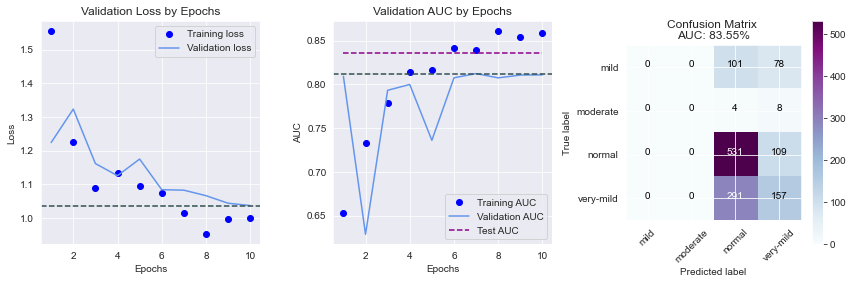

In [14]:

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen)/4,
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=10, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))



y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "vgg19")

# SAVE MODEL
model_dir = "./alzheimer_vgg19_model"
model.save(model_dir, save_format='h5')
np.save('my_vgg19_history.npy', history.history)
#history=np.load('my_vgg19_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

## VGG16

In [ ]:
vgg = VGG16(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()


model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)
tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "vgg16")

# SAVE MODEL
model_dir = "./alzheimer_vgg16_model"
model.save(model_dir, save_format='h5')
np.save('my_vgg16_history.npy', history.history)
#history=np.load('my_vgg16_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

## ResNet50

In [ ]:
rn = ResNet50(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=rn.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "resnet50")

# SAVE MODEL
model_dir = "./alzheimer_resnet50_model"
model.save(model_dir, save_format='h5')
np.save('my_resnet50_history.npy', history.history)
#history=np.load('my_resnet50_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)